# Getting episode metadata and summaries

## Data Sources:
- For Metadata & Summaries: [Memory Alpha](https://memory-alpha.fandom.com/wiki/Portal:Main) (29.08.2022)
- For transcript lines [Chakoteya](http://www.chakoteya.net/) (29.08.2022)

## Datasets

**From Memory Alpha:**
- episode list w/ metadata

| episode | title | abbr | stardate | original_airdate | production_number |
| ---- | :----: | :----: | :----: | :----: | :----: |
| episode | title | abbr | stardate | original_airdate | production_number |  
        
- episode summaries w/ metadata

| episode_abbr | episode_titles | episode_urls | summary_text_clean |
| :----: | :----: | :----: | :----: |
| episode_abbr | episode_titles | episode_urls | summary_text_clean |
        
**From Chakoteya:**  
- episode lines joined to transcript w/o characters w/ metadata

| Series | Seasons | Episodes | Originally released | In Dataset |
| :----: | :----: | :----: | :----: | :----: |
| Series | Seasons | Episodes | Originally released | In Dataset |
        
- episode lines w/ characters & metadata

| Series | Seasons | Episodes | Originally released | In Dataset |
| :----: | :----: | :----: | :----: | :----: |
| Series | Seasons | Episodes | Originally released | In Dataset |



# Setup

In [ ]:
# load package to navigate file system
import os

In [1]:
# Detect whether the notebook is on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
if IN_COLAB:
    #### Set project path in Google Drive
    GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/learning_data_science/projects/text_mining_star_trek/"
    from google.colab import drive
    drive.mount('/content/drive')
    #### Setting Direc
    os.chdir(GDRIVE_PROJECT_PATH)
else:
    # Set working directory relative to this notebook
    os.chdir('..')

In [14]:
# Load packages
import requests
from bs4 import BeautifulSoup
import re
from collections import defaultdict
import pandas as pd

import missingno as msno # missing data visualisation

import matplotlib.pyplot as plt
%matplotlib inline

# Episode Lists & Metadata

In [15]:
# Memory Alpha Star Trek root url
root_url = "https://memory-alpha.fandom.com/wiki/Star_Trek:_"

# List of series names
series_names = ["The Original Series", "The Animated Series", "The Next Generation", "Deep Space Nine",
        "Voyager", "Enterprise", "Discovery", "Picard ", "Lower Decks"]

First, we get all series abbreviations for later reference and then we scrape the HTML page of each series and inspect these for episode information.

The main page of each series contains an infobox with the abbreviation for each series and HTML tables with episode lists for each season.  
The infobox has the CSS class `portable-infobox` and the episode list table has the classes `grey sortable`.



In [16]:
# Create dictionary with Series Abbreviations as keys
# and lists of HTML tables containing episode lists and metadata
# as values

episodes_tbl_dict = defaultdict(dict)

for i, name in enumerate(series_names):
    # create link to series main page
    name = name.replace(' ', '_')
    url = root_url + name
    # get page content
    website_url = requests.get(url).text
    soup = BeautifulSoup(website_url, 'lxml')
    # get series abbreviation
    abbr = soup.find("aside", {"class": "portable-infobox"}) \
        .find("div", {"data-source": "abbr"}) \
        .find("div", {"class": "pi-data-value"}).get_text(strip=True)
    abbr = re.sub('[^A-Za-z0-9]+', '', abbr)
    
    page_url = root_url + name
    
    # Scrape main page for each series
    series_page_url = requests.get(page_url).text
    soup = BeautifulSoup(series_page_url, 'html.parser')

    # get episodes table
    tables = soup.find_all("table", {"class": "grey sortable"})
    episodes_tbl_dict[abbr] = tables
    
    print(series_names[i], " done...")

The Original Series  done...
The Animated Series  done...
The Next Generation  done...
Deep Space Nine  done...
Voyager  done...
Enterprise  done...
Discovery  done...
Picard   done...
Lower Decks  done...


In [17]:
# Print series abbreviations in dictionary
episodes_tbl_dict.keys()

dict_keys(['TOS', 'TAS', 'TNG', 'DS9', 'VOY', 'ENT', 'DIS', 'PIC', 'LD'])

The dictionary now contains the series abbreviations as keys and the lists of scraped HTML tables as values. We can now get the convert the tables to DataFrames.

In [18]:
# Make a list of dataframes from the episode list dictionary.
# Create a new column and assign the series abbreviation to each row.
# Some tables have additional subgrouping within the tables.
# These were read as Multi-index rows and need to be removed.

dfs_list = []

for key, value in episodes_tbl_dict.items():
    tables = value
    episodes_tbls = episodes_tbl_dict[key]
    
    for i, table in enumerate(episodes_tbls):
        pd_table = pd.read_html(str(table))[0]
        # if df has a second index level, e.g. chapters in Discovery series
        if isinstance(pd_table.index, pd.MultiIndex):
            pd_table.columns = pd_table.columns.droplevel(1)
        else:
            pass
        pd_table['Abbr.'] = key
        dfs_list.append(pd_table)

In [19]:
# Combine dataframe lists to one dataframe.
# Index needs to be reset, so it's contiuous throughout the dataset.

# Combine dataframes
combined_dfs = pd.concat(dfs_list)

# Reset index
combined_dfs.reset_index(drop=True, inplace=True)

# Clean up DataFrame

In [20]:
print("Number of rows: ", combined_dfs.shape[0])
print("Number of columns: ", combined_dfs.shape[1])

Number of rows:  834
Number of columns:  21


In [21]:
combined_dfs.columns

Index([                            'Title',
                                 'Episode',
                                 'Prodno.',
                                'Stardate',
                        'Original Airdate',
                      'Remastered Airdate',
                                   'Abbr.',
                       'Production number',
                                    'Date',
                        'Original airdate',
                  ('Title', 'Chapter One'),
                ('Episode', 'Chapter One'),
                ('Prodno.', 'Chapter One'),
               ('Stardate', 'Chapter One'),
       ('Original Airdate', 'Chapter One'),
                             ('Abbr.', ''),
                       ('Title', 'Part 1'),
                     ('Episode', 'Part 1'),
                     ('Prodno.', 'Part 1'),
                    ('Stardate', 'Part 1'),
            ('Original Airdate', 'Part 1')],
      dtype='object')

In [22]:
# Clean up column names
combined_dfs.rename(columns={'Abbr.': 'Abbr_1'}, inplace = True)
combined_dfs.rename(columns=''.join, inplace=True)
combined_dfs.columns = combined_dfs.columns.str.strip().str.replace(' ', '_')

In [23]:
combined_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Title                        803 non-null    object
 1   Episode                      803 non-null    object
 2   Prodno.                      706 non-null    object
 3   Stardate                     676 non-null    object
 4   Original_Airdate             696 non-null    object
 5   Remastered_Airdate           80 non-null     object
 6   Abbr_1                       803 non-null    object
 7   Production_number            97 non-null     object
 8   Date                         127 non-null    object
 9   Original_airdate             107 non-null    object
 10  TitleChapter_One             16 non-null     object
 11  EpisodeChapter_One           16 non-null     object
 12  Prodno.Chapter_One           16 non-null     object
 13  StardateChapter_One          16 non

In [24]:
# Check for missing data
combined_dfs.isna().sum()

Title                           31
Episode                         31
Prodno.                        128
Stardate                       158
Original_Airdate               138
Remastered_Airdate             754
Abbr_1                          31
Production_number              737
Date                           707
Original_airdate               727
TitleChapter_One               818
EpisodeChapter_One             818
Prodno.Chapter_One             818
StardateChapter_One            818
Original_AirdateChapter_One    818
Abbr.                          803
TitlePart_1                    819
EpisodePart_1                  819
Prodno.Part_1                  819
StardatePart_1                 819
Original_AirdatePart_1         819
dtype: int64

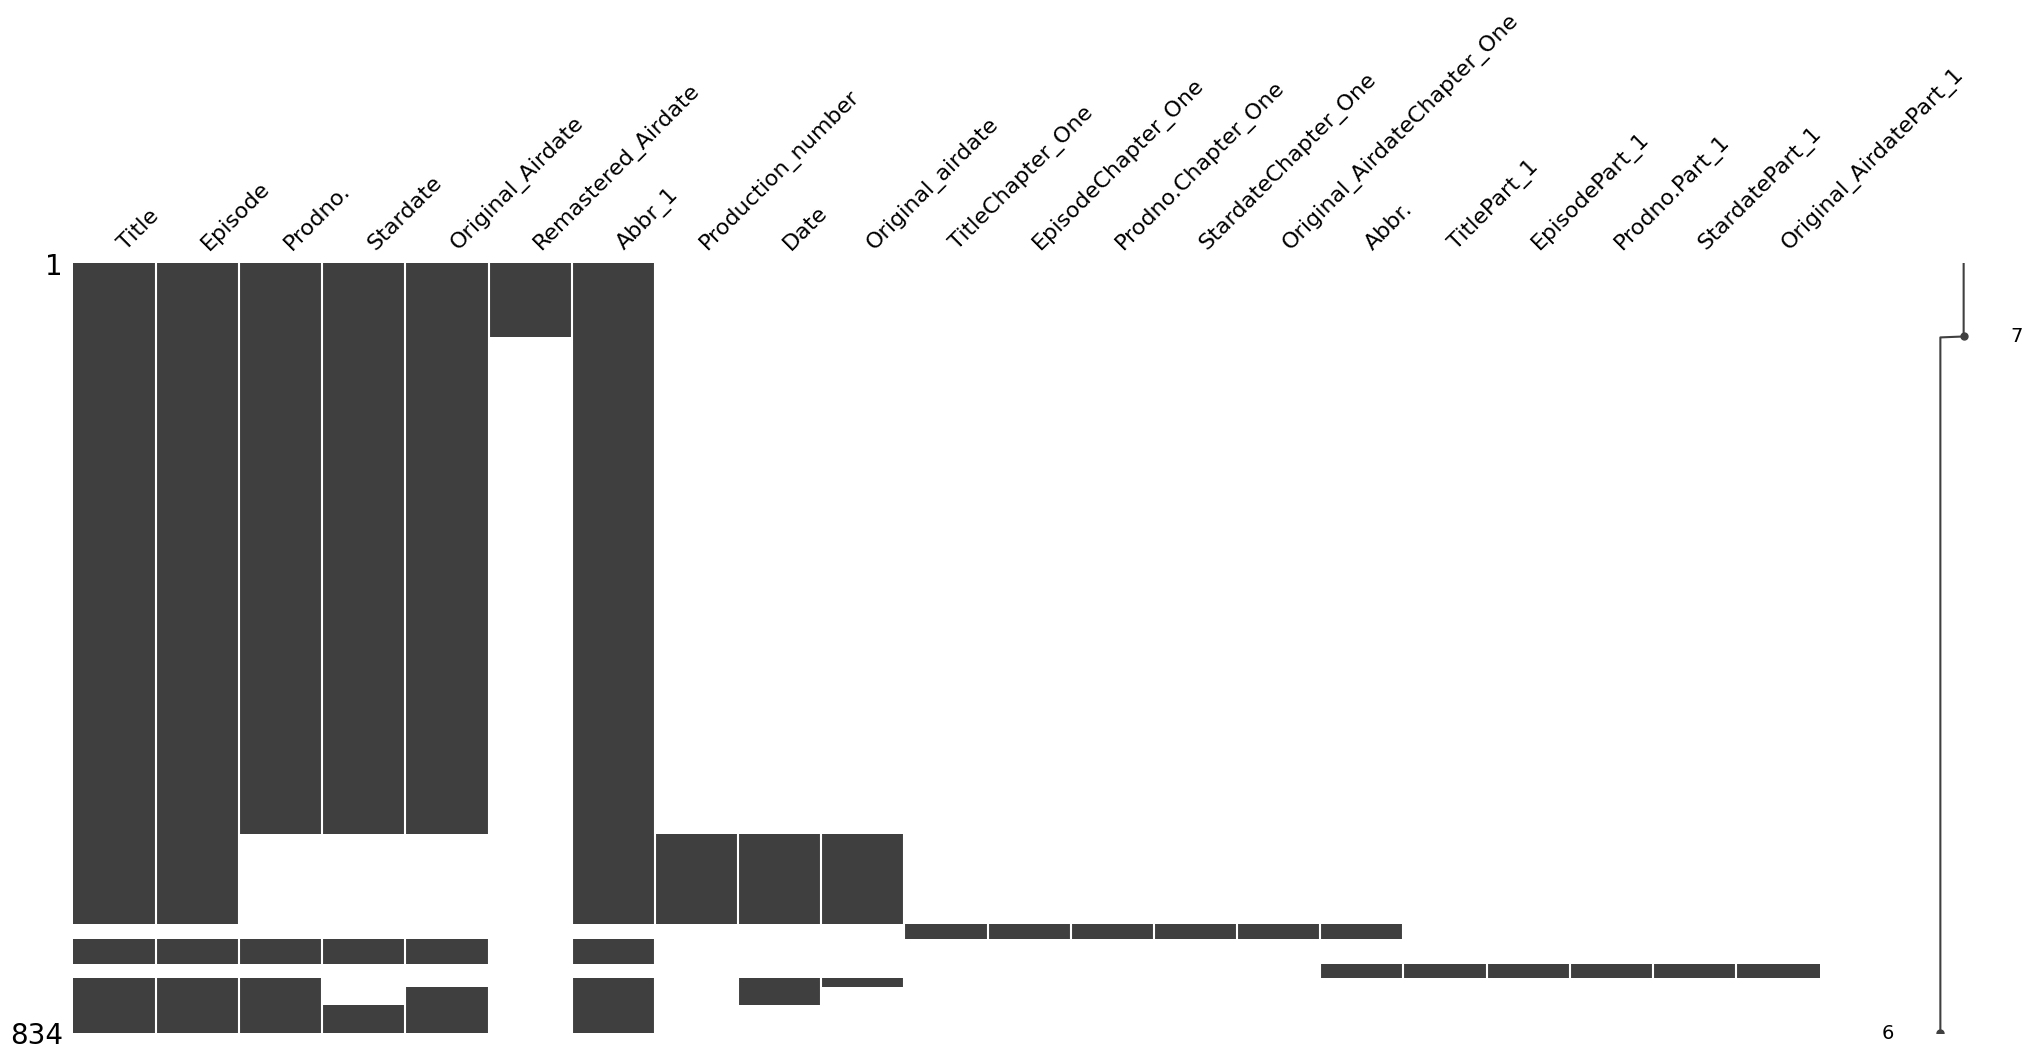

In [25]:
# Check structure of missing data
msno.matrix(combined_dfs)
plt.show()

Columns containing the same information
- `Abbr_1` and `Abbr.`
- `Episode`, `EpisodeChapter_One` & `EpisodePart_1`
- `Title`, `TitleChapter_One` & `TitlePart_1`
- `Stardate`, `StardateChapter_One` & `StardatePart_1`
- `Original_Airdate`, `Original_AirdateChapter_One`, `Original_AirdatePart_1` & `Original_airdate`
- `Prodno.`, `Production_number`, `Prodno.Chapter_One` & `Prodno.Part_1`

In [26]:
# Columns have different names but contain same info due to MultiIndexing.
# Combine info from the respective columns.

# Define functions for combining two or three columns
def combine_two_cols(a, b):
    result = ''
    if pd.isnull(a):
        result = b   
    else:
        result = a
    return result

def combine_three_cols(a, b, c):
    result = ''
    if pd.isnull(a):
        if pd.isnull(b):
            return c
        else:
            return b
    else:
        result = a
    return result

In [27]:
# clean up series abbreviations
combined_dfs['abbr'] = combined_dfs.apply(lambda row : combine_two_cols(row['Abbr_1'], \
                                                row['Abbr.']), axis = 1)

In [28]:
# clean up episode ids
combined_dfs['episode'] = combined_dfs.apply(lambda row : combine_three_cols(row['Episode'], \
                                                row['EpisodeChapter_One'], row['EpisodePart_1']), \
                                             axis = 1)

In [29]:
# clean up episode titles
combined_dfs['title'] = combined_dfs.apply(lambda row : combine_three_cols(row['Title'], \
                                                row['TitleChapter_One'], row['TitlePart_1']), \
                                             axis = 1)

In [30]:
# clean up stardates
combined_dfs['stardate'] = combined_dfs.apply(lambda row : combine_three_cols(row['Stardate'], \
                                                row["StardateChapter_One"], row['StardatePart_1']), axis = 1)

In [31]:
# clean up orginal airdates
combined_dfs['original_airdate'] = combined_dfs.apply(lambda row : combine_two_cols(row['Original_Airdate'], \
                                                                                    row['Original_airdate']), axis = 1)

combined_dfs['original_airdate'] = combined_dfs.apply(lambda row : combine_three_cols(row['original_airdate'], \
                                                row["Original_AirdateChapter_One"], row['Original_AirdatePart_1']), axis = 1)

In [32]:
# Clean up production numbers
combined_dfs['production_number'] = combined_dfs.apply(lambda row : combine_two_cols(row['Prodno.'], \
                                                                                    row['Production_number']), axis = 1)

combined_dfs['production_number'] = combined_dfs.apply(lambda row : combine_three_cols(row['production_number'], \
                                                row["Prodno.Chapter_One"], row['Prodno.Part_1']), axis = 1)

Some old episodes were remastered and the airing of those episodes is given in a separate column. This was only done for some older episodes of the series and is not interesting in the context of this dataset.

In [33]:
# drop unnecessary columns
cols_to_drop = ['Abbr_1', 'Abbr.', 'Episode',
                'EpisodeChapter_One', 'EpisodePart_1',
                'Title', 'TitleChapter_One', 'TitlePart_1',
                'Stardate', 'StardateChapter_One', 'StardatePart_1',
                'Original_Airdate', 'Original_airdate', 'Original_AirdateChapter_One', 'Original_AirdatePart_1',
                'Prodno.', 'Production_number', 'Prodno.Chapter_One', 'Prodno.Part_1',
                'Remastered_Airdate'] # drop remastered airdate 

st_metadata_df = combined_dfs.drop(cols_to_drop, axis=1)

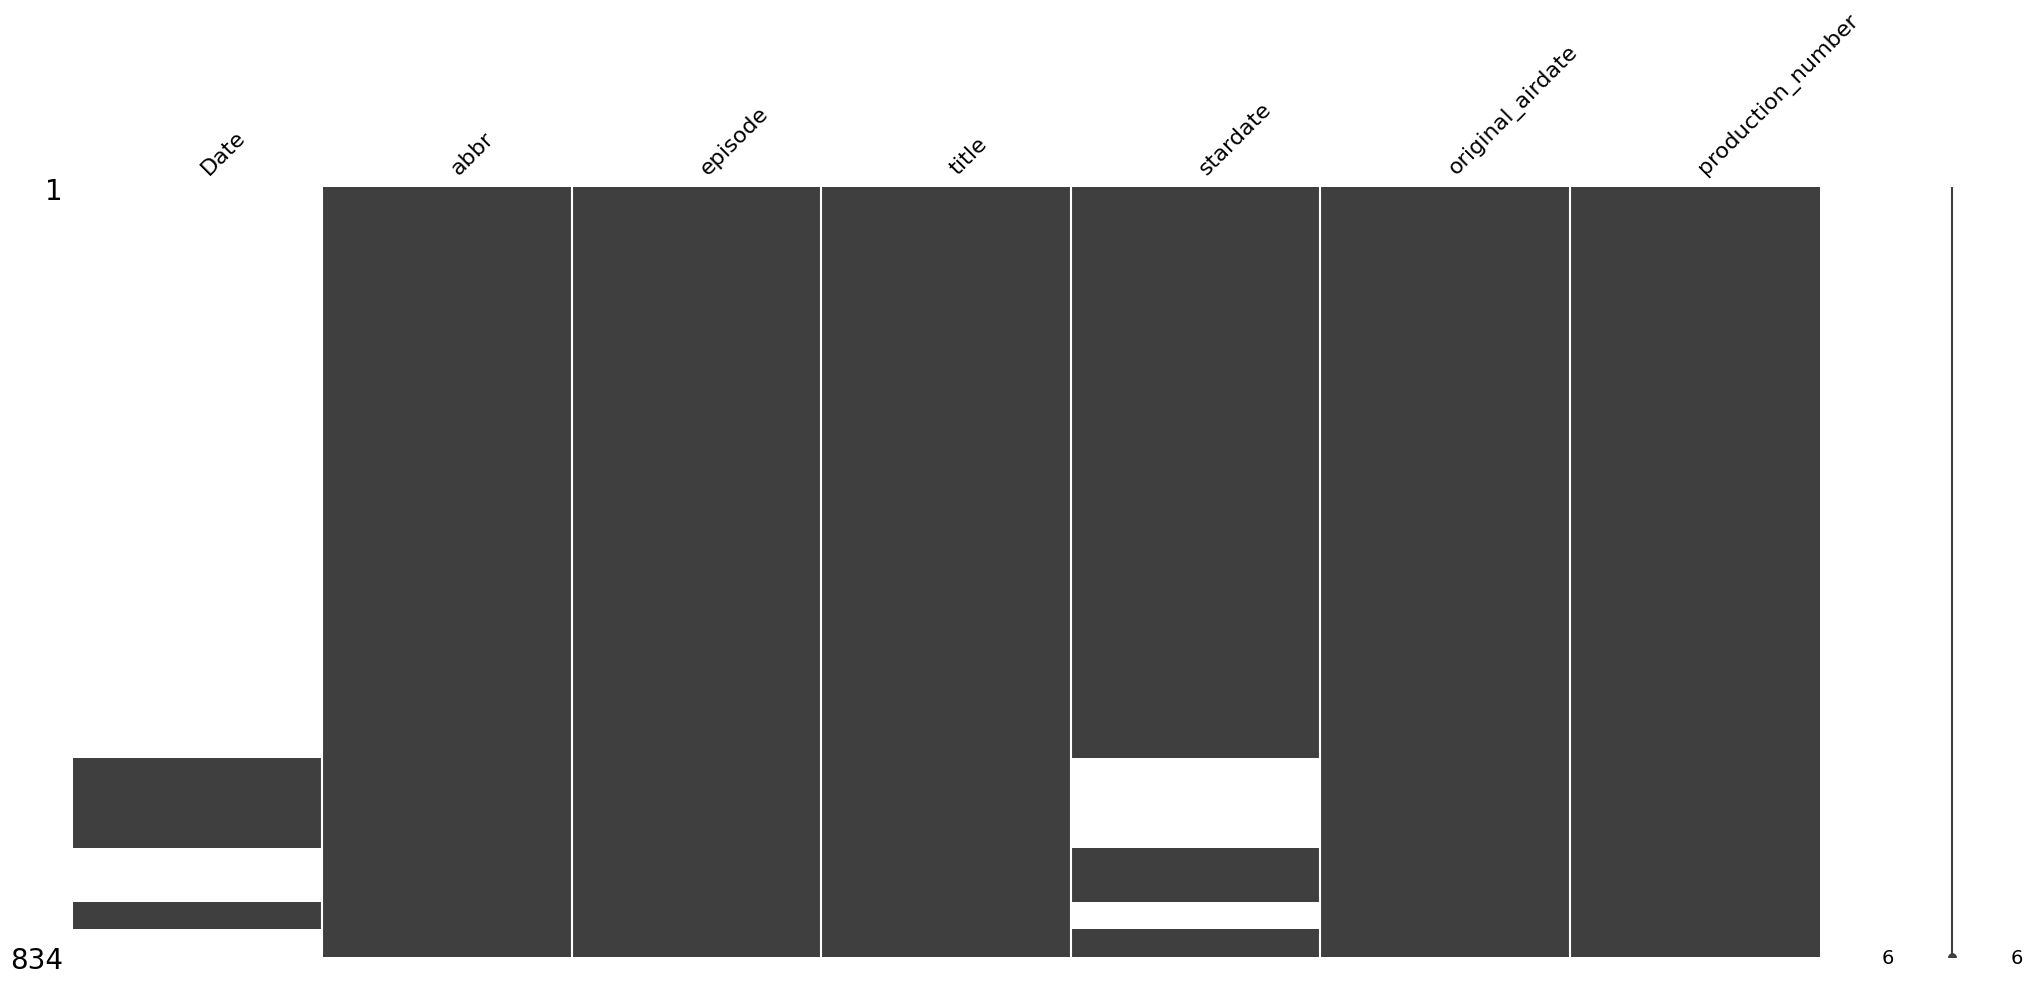

In [34]:
# Check structure of missing data
msno.matrix(st_metadata_df)
plt.show()

In [35]:
st_metadata_df.head()

,Date,abbr,episode,title,stardate,original_airdate,production_number
0,NaN,TOS,0x01,The Cage,Unknown,1988-10-04,6149-01
1,NaN,TOS,1x01,Where No Man Has Gone Before,1312.4 - 1313.8,1966-09-22,6149-02
2,NaN,TOS,1x02,The Corbomite Maneuver,1512.2 - 1514.1,1966-11-10,6149-03
3,NaN,TOS,1x03,Mudd's Women,1329.8 - 1330.1,1966-10-13,6149-04
4,NaN,TOS,1x04,The Enemy Within,1672.1 - 1673.1,1966-10-06,6149-05


The `Date` column could contain the missing values for Stardates, but the naming is ambiguous.

In [36]:
# Unique values in Date column.
st_metadata_df[st_metadata_df['Date'].notna()]['Date'].unique()

array(['2151-04-16', '2151-05-06', 'Unknown', '2151-06-19', '2151-07-31',
       '2151-09-09', '2151-09-01', '2151-11-09', '2152-02-09',
       '2152-02-12', '2152-02-18', '2152-04-12', '2152-08-14',
       '2152-09-12', '2152-09-18', '2153-01-10', '2153-03-01',
       '2153-03-21', '2153-04-24', '2153-12-06', '2153-12-12',
       '2153-12-27', '2154-01-08', '2154-01', '2154-02-12', '2154-02-13',
       '2154-02-14', '2154-05-17', '2154-05-27', '2154-11-12',
       '2154-11-15', '2154-11-27', '2154-12', '2154-12-27', '2155-01-13',
       '2155-01-18', '2155-01-19', '2155-01-22', '47457.1', '2399',
       '2399 / 2385', '2399 / 2386', '2401', '2401 / April 12, 2024',
       'April 12, 2024', 'April 13, 2024', 'April 13-14, 2024',
       'April 14, 2024'], dtype=object)

Most dates refer to actual dates in the series context, they don't represent stardates though. Also some dates seem to be airdates for episodes, e.g. 'April 14, 2024'.

Inspect the dates refering to the year 2024

In [37]:
# List of "present" dates
present_dates = ['April 12, 2024', 'April 13, 2024', 'April 13-14, 2024',
       'April 14, 2024']

In [38]:
st_metadata_df[st_metadata_df['Date'].isin(present_dates)]

,Date,abbr,episode,title,stardate,original_airdate,production_number
787,"April 12, 2024",PIC,2x04,Watcher,NaN,2022-03-24,204
788,"April 12, 2024",PIC,2x05,Fly Me to the Moon,NaN,2022-03-31,205
789,"April 12, 2024",PIC,2x06,Two of One,NaN,2022-04-07,206
790,"April 13, 2024",PIC,2x07,Monsters,NaN,2022-04-14,207
791,"April 13-14, 2024",PIC,2x08,Mercy,NaN,2022-04-21,208
792,"April 14, 2024",PIC,2x09,Hide and Seek,NaN,2022-04-28,209


The episodes where the date is in the year 2024 are all in the second season of the series *Picard*. The series involves time travel into the past, to the year 2024, so these can be counted as stardates.

In some episodes the stardate is not mentioned, these are denoted with `Unknown` and some episodes have the actual date instead of the stardate. But given that all entries in the `Date` column refer to the date the given episode takes place, we can consider them as stardates.

In [39]:
# Combine Date and stardate columns
st_metadata_df['stardate'] = st_metadata_df.apply(lambda row : combine_two_cols(row['stardate'], \
                                                                                    row['Date']), axis = 1)
st_metadata_df = st_metadata_df.drop('Date', axis=1)

In [40]:
# Dimensions of final Dataframe
st_metadata_df.shape

(834, 6)

In [41]:
# Check for missing data
st_metadata_df.isna().sum()

abbr                 0
episode              0
title                0
stardate             0
original_airdate     0
production_number    0
dtype: int64

In [ ]:
# export DataFrame to csv file
with open('./data/raw/st_metadata.csv', 'w', encoding='utf-8-sig') as f:
  st_metadata_df.to_csv(f)

# Episode Summaries

Memory Alpha has a page for each episode. On these episode pages we can find a summary of the episode plot. To get these summaries we need to get URLs for each episode and scrape the summary sections.  
To do this we first need to work with the episode lists tables again. These contain not only the titles of the episodes, but also a link to the episodes pages. The goal is to build a table that contains the series abbreviations and episode titles to have a unique combination on which we can later join different datasets and a column containing the summary text for each episode.

## Episode URLs

In [79]:
# function to parse episode title and URL
def parse_table(table):
    episode_root_url = 'https://memory-alpha.fandom.com'
    titles_lst = []
    urls_lst = []
    texts_lst = []

    for tr in table.select('tr'):
        # find all direct children of tr and if all of them have the name 'th', 
        # append corresponding tr to dict 'head'
        if all(t.name == 'th' for t in tr.find_all(recursive=False)): 
            pass
        else: 
            if tr.find_all("td")[0].find('a'):
                title = tr.find_all("td")[0].find('a').get_text()
                titles_lst.append(title)
                link = episode_root_url + tr.find_all("td")[0].find('a').get('href')
                urls_lst.append(link)
            else:
                pass
    return titles_lst, urls_lst

In [84]:
# lists for episode abbreviations, titles, URLs
episode_abbr = []
episode_titles = []
episode_urls = []

# scrape links and metadata from series page
for i, name in enumerate(series_names):
    # create URL to series main page
    name = name.replace(' ', '_')
    url = root_url + name

    # get page content
    website_url = requests.get(url).text
    soup = BeautifulSoup(website_url, 'lxml')

    # get series abbreviations
    abbr = soup.find('aside', {'class': 'portable-infobox'}) \
        .find('div', {'data-source': 'abbr'}) \
        .find('div', {'class': 'pi-data-value'}).get_text(strip=True)
    abbr = re.sub('[^A-Za-z0-9]+', '', abbr)

    # get episodes table
    tables = soup.find_all('table', {'class': 'grey sortable'})

    # extract data from tables and write into lists
    for table in tables:
        titles, urls = parse_table(table)
        episode_titles.append(titles)
        episode_urls.append(urls)
        abbr_lst = [abbr] * len(titles)
        episode_abbr.append(abbr_lst)
    

In [86]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [89]:
# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
episode_abbr = flatten(episode_abbr)
episode_titles = flatten(episode_titles)
episode_urls = flatten(episode_urls)

In [90]:
episodes_urls_dict = {'episode_abbr': episode_abbr, 
                      'episode_titles': episode_titles, 
                      'episode_urls': episode_urls} 

episodes_urls_df = pd.DataFrame(episodes_urls_dict)

In [91]:
episodes_urls_df

,episode_abbr,episode_titles,episode_urls
0,TOS,The Cage,https://memory-alpha.fandom.com/wiki/The_Cage_...
1,TOS,Where No Man Has Gone Before,https://memory-alpha.fandom.com/wiki/Where_No_...
2,TOS,The Corbomite Maneuver,https://memory-alpha.fandom.com/wiki/The_Corbo...
3,TOS,Mudd's Women,https://memory-alpha.fandom.com/wiki/Mudd%27s_...
4,TOS,The Enemy Within,https://memory-alpha.fandom.com/wiki/The_Enemy...
...,...,...,...
809,LD,"I, Excretus","https://memory-alpha.fandom.com/wiki/I,_Excret..."
810,LD,wej Duj,https://memory-alpha.fandom.com/wiki/Wej_Duj_(...
811,LD,First First Contact,https://memory-alpha.fandom.com/wiki/First_Fir...
812,LD,Grounded,https://memory-alpha.fandom.com/wiki/Grounded_...


## Episode summaries

In [92]:
# funtion to clean summary texts
def clean_summary_html(soup):
    for s in soup.select('script'):
        s.extract()

    for s in soup.select('meta'):
        s.extract()

    for s in soup.select('link'):
        s.extract()
    
    soup = str(soup)
    
    sep_start = 'id="Summary"'
    sep_end = 'id="Memorable_quotes"'

    stripped = soup.split(sep_start, 1)[1]
    stripped = stripped.split(sep_end, 1)[0]

    summary_text = BeautifulSoup(stripped, 'lxml').text
    return summary_text

In [93]:
# function to scrape episode summaries from episode pages
def get_summary_html(url):
    episode_page_url = requests.get(url).text
    soup = BeautifulSoup(episode_page_url, 'lxml')
    summary_text = clean_summary_html(soup)
    return summary_text

In [94]:
# 
episodes_urls_df['summary_text'] = episodes_urls_df.apply(lambda row : get_summary_html(row['episode_urls']), axis = 1)

In [95]:
episodes_urls_df

,episode_abbr,episode_titles,episode_urls,summary_text
0,TOS,The Cage,https://memory-alpha.fandom.com/wiki/The_Cage_...,>Summary\n Captain Pike on the bridge \nThe...
1,TOS,Where No Man Has Gone Before,https://memory-alpha.fandom.com/wiki/Where_No_...,">Summary\nTeaser\n ""I'll have you checkmate..."
2,TOS,The Corbomite Maneuver,https://memory-alpha.fandom.com/wiki/The_Corbo...,>Summary\nTeaser\n The mysterious object \...
3,TOS,Mudd's Women,https://memory-alpha.fandom.com/wiki/Mudd%27s_...,>Summary\nTeaser\nThe USS Enterprise chases an...
4,TOS,The Enemy Within,https://memory-alpha.fandom.com/wiki/The_Enemy...,">Summary\nTeaser\nDuring a survey of Alfa 177,..."
...,...,...,...,...
809,LD,"I, Excretus","https://memory-alpha.fandom.com/wiki/I,_Excret...",">Summary\nTeaser\nEnsigns Beckett Mariner, Bra..."
810,LD,wej Duj,https://memory-alpha.fandom.com/wiki/Wej_Duj_(...,">Summary\nAct One\n""Captain's log: the Cerrito..."
811,LD,First First Contact,https://memory-alpha.fandom.com/wiki/First_Fir...,">Summary\nTeaser\n""Captain's log, Stardate 581..."
812,LD,Grounded,https://memory-alpha.fandom.com/wiki/Grounded_...,">Summary\nTeaser\n""I'm Sylvia Ront, and this i..."


In [96]:
def clean_summary_text(text):
    # remove first occurence of words 'summary' and 'teaser'
    if "Summary" in text:
        text = text.replace("Summary","",1)
        
    if "Teaser" in text:
        text = text.replace("Teaser","",1)
        
    # replace newline characters with space
    clean_text = text.replace("\n", " ")
    
    # remove repeated whitespace inside a string
    clean_text = re.sub('\s+',' ', clean_text)
    
    # remove >, "" characters
    clean_text = clean_text.replace('>', '')
    
    return clean_text

In [97]:
episodes_urls_df['summary_text_clean'] = episodes_urls_df.apply(lambda row : clean_summary_text(row['summary_text']), \
                                                          axis = 1)

In [98]:
episodes_urls_df

,episode_abbr,episode_titles,episode_urls,summary_text,summary_text_clean
0,TOS,The Cage,https://memory-alpha.fandom.com/wiki/The_Cage_...,>Summary\n Captain Pike on the bridge \nThe...,"Captain Pike on the bridge The year is 2254, ..."
1,TOS,Where No Man Has Gone Before,https://memory-alpha.fandom.com/wiki/Where_No_...,">Summary\nTeaser\n ""I'll have you checkmate...","""I'll have you checkmated your next move…"" ""C..."
2,TOS,The Corbomite Maneuver,https://memory-alpha.fandom.com/wiki/The_Corbo...,>Summary\nTeaser\n The mysterious object \...,The mysterious object The USS Enterprise is i...
3,TOS,Mudd's Women,https://memory-alpha.fandom.com/wiki/Mudd%27s_...,>Summary\nTeaser\nThe USS Enterprise chases an...,The USS Enterprise chases an unregistered sta...
4,TOS,The Enemy Within,https://memory-alpha.fandom.com/wiki/The_Enemy...,">Summary\nTeaser\nDuring a survey of Alfa 177,...","During a survey of Alfa 177, geological techn..."
...,...,...,...,...,...
809,LD,"I, Excretus","https://memory-alpha.fandom.com/wiki/I,_Excret...",">Summary\nTeaser\nEnsigns Beckett Mariner, Bra...","Ensigns Beckett Mariner, Brad Boimler, D'Vana..."
810,LD,wej Duj,https://memory-alpha.fandom.com/wiki/Wej_Duj_(...,">Summary\nAct One\n""Captain's log: the Cerrito...","Act One ""Captain's log: the Cerritos is begin..."
811,LD,First First Contact,https://memory-alpha.fandom.com/wiki/First_Fir...,">Summary\nTeaser\n""Captain's log, Stardate 581...","""Captain's log, Stardate 58130.6. The Cerrito..."
812,LD,Grounded,https://memory-alpha.fandom.com/wiki/Grounded_...,">Summary\nTeaser\n""I'm Sylvia Ront, and this i...","""I'm Sylvia Ront, and this is FNN's continuin..."


In [99]:
# Drop original summary_text column
episodes_summaries_df = episodes_urls_df.drop(['summary_text'], axis=1)

In [100]:
# Check dimensions of Dataframe
episodes_summaries_df.shape

(814, 4)

In [101]:
# Check for missing data
episodes_summaries_df.isna().sum()

episode_abbr          0
episode_titles        0
episode_urls          0
summary_text_clean    0
dtype: int64

In [103]:
# Export to st_metadata.csv
episodes_summaries_df.to_csv(r'./data/raw/st_summaries.csv', index = False)